# Mini Project #3
##### 워싱턴 킹 카운티 주택 거래 가격 예측


In [22]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from datetime import datetime

# Data Analyzing & Feature Engineering

#### 거래 일자 (date) 특성에 의미를 부여한 'year' 특성을 만들고 'date' 특성은 없앰
#### SimpleImputer 를 통해 데이터 셋 결측값 방지

In [24]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer()

x=["date","price","bedrooms","bathrooms","sqft_living","sqft_lot","floors","waterfront","view","condition","grade","sqft_above","sqft_basement","yr_built","yr_renovated","zipcode","lat","long","sqft_living15","sqft_lot15"]

df = pd.DataFrame(housing, columns=x)
df['year'] = pd.DatetimeIndex(df['date']).year
df = df.drop(['date'], axis=1)

df = pd.DataFrame(imputer.fit_transform(df))
df.columns = ["price","bedrooms","bathrooms","sqft_living","sqft_lot","floors","waterfront","view","condition","grade","sqft_above","sqft_basement","yr_built","yr_renovated","zipcode","lat","long","sqft_living15","sqft_lot15","year"]

df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year
count,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652,2014.322954
std,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631,0.467616
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,2014.000000
25%,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000,2014.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000,2014.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000,2015.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000,2015.000000


#### Price 의 스케일을 낮춤

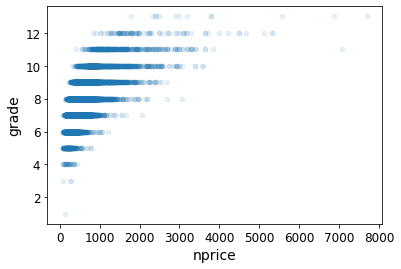

In [25]:
df['nprice'] = df['price'] / 1000
df.plot.scatter(x='nprice',y='grade', alpha=0.1)

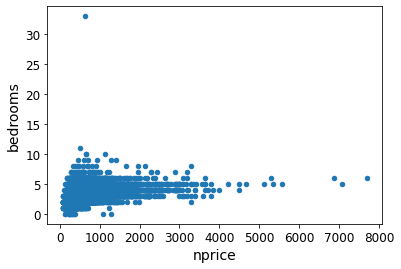

In [27]:
df.plot.scatter(x='nprice',y='bedrooms', alpha=1)

#### Bedrooms 특성에 이상치 (33) 가 있으므로 제거해줌

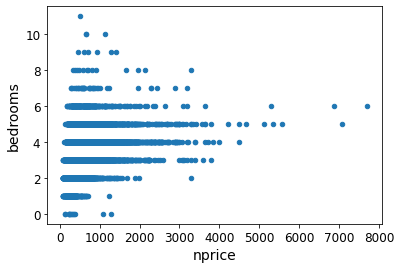

In [28]:
df = df[df.bedrooms != 33]
df.plot.scatter(x='nprice',y='bedrooms',alpha=1)

In [12]:
df.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,nprice
price,1.000000,0.315445,0.525147,0.702047,0.089664,0.256811,0.266371,0.397299,0.036336,0.667447,...,0.323812,0.054023,0.126437,-0.053209,0.306998,0.021637,0.585404,0.082451,0.003585,1.000000
bedrooms,0.315445,1.000000,0.529159,0.591467,0.032807,0.181085,-0.006611,0.081930,0.025478,0.366502,...,0.309490,0.159167,0.019617,-0.157093,-0.010541,0.133882,0.402626,0.030402,-0.009035,0.315445
bathrooms,0.525147,0.529159,1.000000,0.754663,0.087735,0.500645,0.063742,0.187732,-0.124946,0.664979,...,0.283789,0.506012,0.050735,-0.203858,0.024594,0.223028,0.568628,0.087170,-0.026612,0.525147
sqft_living,0.702047,0.591467,0.754663,1.000000,0.172822,0.353937,0.103816,0.284606,-0.058704,0.762701,...,0.435065,0.318037,0.055358,-0.199421,0.052552,0.240209,0.756419,0.183280,-0.029055,0.702047
sqft_lot,0.089664,0.032807,0.087735,0.172822,1.000000,-0.005210,0.021603,0.074707,-0.008935,0.113616,...,0.015293,0.053073,0.007641,-0.129571,-0.085675,0.229516,0.144602,0.718556,0.005461,0.089664
floors,0.256811,0.181085,0.500645,0.353937,-0.005210,1.000000,0.023695,0.029432,-0.263706,0.458171,...,-0.245684,0.489302,0.006330,-0.059102,0.049655,0.125388,0.279856,-0.011282,-0.022345,0.256811
waterfront,0.266371,-0.006611,0.063742,0.103816,0.021603,0.023695,1.000000,0.401857,0.016665,0.082773,...,0.080591,-0.026165,0.092884,0.030287,-0.014270,-0.041914,0.086461,0.030702,-0.004168,0.266371
view,0.397299,0.081930,0.187732,0.284606,0.074707,0.029432,0.401857,1.000000,0.046031,0.251315,...,0.276959,-0.053452,0.103915,0.084834,0.006170,-0.078413,0.280432,0.072571,0.001354,0.397299
condition,0.036336,0.025478,-0.124946,-0.058704,-0.008935,-0.263706,0.016665,0.046031,1.000000,-0.144632,...,0.174057,-0.361380,-0.060602,0.002973,-0.015048,-0.106423,-0.092731,-0.003373,-0.045518,0.036336
grade,0.667447,0.366502,0.664979,0.762701,0.113616,0.458171,0.082773,0.251315,-0.144632,1.000000,...,0.168412,0.446952,0.014409,-0.184852,0.114111,0.198355,0.713198,0.119241,-0.030405,0.667447


#### 훈련 데이터, 레이블 분리

In [13]:
housing_labels=df.price
housing_prepared=df.drop(['price'],axis=1)

In [14]:
housing_prepared['bathrooms'].value_counts()

2.50    5380
1.00    3852
1.75    3047
2.25    2047
2.00    1930
1.50    1446
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      72
4.75      23
5.00      21
5.25      13
0.00      10
5.50      10
1.25       9
6.00       6
0.50       4
5.75       4
8.00       2
6.25       2
6.50       2
6.75       2
7.50       1
7.75       1
Name: bathrooms, dtype: int64

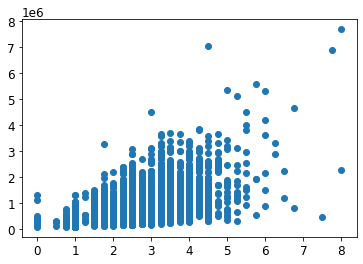

In [15]:
plt.scatter(housing_prepared['bathrooms'], housing_labels)

# Evaluating Models

In [16]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [17]:
seed = 42
num_folds = 10
scoring = 'neg_mean_squared_error'

#### 대표적인 예측(회귀) 모델들의 성능 평가

In [46]:
models = []
models.append(('LR', LinearRegression()))
models.append(('CART', DecisionTreeRegressor(random_state=seed)))
models.append(('RF', RandomForestRegressor(random_state=seed, n_estimators=100)))
models.append(('ET', ExtraTreesRegressor(random_state=seed, n_estimators=100)))
models.append(('AB', AdaBoostRegressor(random_state=seed)))
models.append(('GBM', GradientBoostingRegressor(random_state=seed )))
results = []
names = []
metrics = []

In [47]:
for name, model in models:
    cv_results = cross_val_score(model, housing_prepared, housing_labels, cv=num_folds, scoring=scoring)
    cv_scores = np.sqrt(-cv_results)
    results.append(cv_scores)
    names.append(name)
    metrics.append(cv_scores.mean())
    msg = "%s: %f (%f)" % (name, cv_scores.mean(), cv_scores.std())
    print(msg)
print ('Average metrics (RMSE) from all models:',np.mean(metrics))

LR: 0.000000 (0.000000)
CART: 14608.748195 (18260.912037)
SVM: 377274.151092 (23678.200304)
RF: 9672.850678 (10473.991831)
ET: 9319.525364 (6989.335400)
AB: 69470.443076 (6408.622480)
GBM: 9577.122704 (6152.772613)
Average metrics (RMSE) from all models: 69988.97730128621


#### ExtraTreesRegressor 성능이 가장 좋은 것을 확인

In [48]:
et_reg = ExtraTreesRegressor(random_state=42, n_estimators=100)
et_reg.fit(housing_prepared, housing_labels)

ExtraTreesRegressor(random_state=42)

In [49]:
et_scores = cross_val_score(et_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=num_folds)
et_rmse_scores = np.sqrt(-et_scores)
display_scores(et_rmse_scores)

Scores: [ 7209.81403053 23347.73521541  3351.94962442 19123.81254033
  3644.1023763  15184.36161757  6512.29819087  2667.20433859
  8884.28225906  3269.69344466]
Mean: 9319.525363773088
Standard deviation: 6989.3354004454


### 최종 RMSE : 9319.52